# Augment for Publication!

In [2]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *
from scipy.ndimage import zoom

In [3]:
subject = tio.Subject(
    image_t1=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T1w_hires.nii.gz'),
    image_t2=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T2w_hires.nii.gz'),
    mask = tio.LabelMap('/media/hdd/HCP_1200/100206/T1w/brainmask_fs.nii.gz')
)
# input shape [sagital, coronal, axial]

<Figure size 1440x720 with 0 Axes>

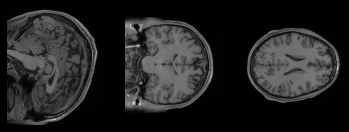

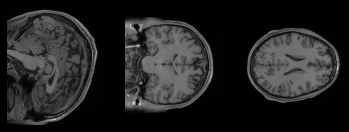

In [4]:
display_multiplanar_center(subject.image_t1.data.cpu().numpy()[0])

In [6]:
spacing = np.array([1.5,1.5,5.])
def augment_and_save(subject, augment_func, save_name):
    save_path = '/media/hdd/viscent/SR-UNet/inference/publish_journal/augmentation'
    augmented_subject = augment_func(subject)
    subject_array = augmented_subject.image_t2.data.cpu().numpy()[0]
    subject_array = zoom(subject_array, augmented_subject.image_t2.spacing)
    subject_shape = subject_array.shape
    fig = plt.Figure(dpi=1200)
    plt.imshow(subject_array[subject_shape[1]//2,:,:], cmap='gray')
    plt.axis('off')
    plt.gcf()
    plt.savefig(save_path + '/' + save_name + '.png', dpi=1200)
    return augmented_subject

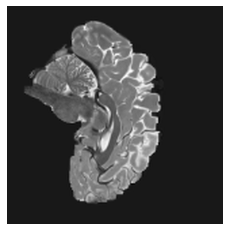

In [7]:
subject = tio.Subject(
    image_t1=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T1w_hires.nii.gz'),
    image_t2=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T2w_hires.nii.gz'),
    mask = tio.LabelMap('/media/hdd/HCP_1200/100206/T1w/brainmask_fs.nii.gz')
)
subject_gt = tio.Subject(
    image_t1=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T1w_hires.nii.gz'),
    image_t2=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T2w_hires.nii.gz'),
    mask = tio.LabelMap('/media/hdd/HCP_1200/100206/T1w/brainmask_fs.nii.gz')
)

subject_array = subject.image_t2.data.cpu().numpy()[0]
subject_shape = subject_array.shape

fig = plt.Figure(dpi=1200)
plt.imshow(subject_array[subject_shape[1]//2,:,:], cmap='gray')
plt.axis('off')
plt.gcf()
plt.savefig('/media/hdd/viscent/SR-UNet/inference/publish_journal/augmentation' + '/' + 'subject_0' + '.png', dpi=1200)

transforms = [
    tio.Mask(masking_method='mask'),
    tio.transforms.Resample(spacing),
    tio.transforms.Resample((1.,1.,1.)),
    tio.transforms.RandomGamma((0.4,0.4))
]

transforms_gt = [
    tio.Mask(masking_method='mask'),
    tio.transforms.Resample((1.,1.,1.)),
]
for i, transform in enumerate(transforms):
    subject = augment_and_save(subject, transform, 'augment_' + str(i+1))
for i, transform in enumerate(transforms_gt):
    subject_gt = augment_and_save(subject_gt, transform, 'gt_' + str(i+1))

edge_max = max(subject.image_t2.data.shape)
padding = ((edge_max - subject.image_t2.data.shape[1]) // 2, 
            (edge_max - subject.image_t2.data.shape[2]) // 2,
                (edge_max - subject.image_t2.data.shape[3]) // 2)

base_aug = 1+len(transforms)
base_gt = 1+len(transforms_gt)

transforms = [
    tio.Pad(padding),
    tio.transforms.Resize((160,160,160)),
]

transforms_gt = [
    tio.Pad(padding),
    tio.transforms.Resize((160,160,160)),
]

for i, transform in enumerate(transforms):
    subject = augment_and_save(subject, transform, 'augment_' + str(i+base_aug))
for i, transform in enumerate(transforms_gt):
    subject_gt = augment_and_save(subject_gt, transform, 'gt_' + str(i+base_gt))

# Kornia Augmentation

In [20]:
import kornia.augmentation as K
transform_spatial_1 = K.RandomRotation3D((15., 20., 20.), p=1,keepdim=True)
transform_spatial_2 = K.RandomAffine3D((15., 20., 20.), p=1,keepdim=True)
transform_intensity_1 = K.RandomMotionBlur3D(3, 35., 0.5, p=1,keepdim=True)
transform_intensity_2 = lambda x: x + torch.randn_like(x)*15 if np.random.rand() < 1 else x

image_tensor = subject.image_t2.data.squeeze(0)


In [8]:
def kornia_and_save(image_tensor, augment_func, save_name):
    save_path = '/media/hdd/viscent/SR-UNet/inference/publish_journal/augmentation'
    ret = augment_func(image_tensor)
    ret = ret.squeeze(0).squeeze(0).cpu().numpy()
    fig = plt.Figure(dpi=1200)
    plt.imshow(ret[ret.shape[0]//2,:,:], cmap='gray')
    plt.axis('off')
    plt.gcf()
    plt.savefig(save_path + '/' + save_name + '.png', dpi=1200)

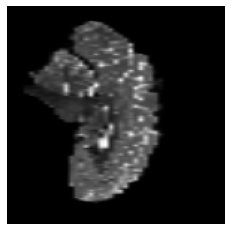

In [21]:
transforms_kornia = [
    transform_spatial_1,
    transform_spatial_2,
    transform_intensity_1,
    transform_intensity_2,
]
for i, transform in enumerate(transforms_kornia):
    kornia_and_save(image_tensor, transform, 'kornia_' + str(transforms_kornia[i].__class__.__name__+str(len(transforms))))

In [16]:
transform_spatial_1.__class__.__name__

'RandomRotation3D'

In [ ]:
import torchio as tio
spacing = np.array([1.5,1.5,5.])

subject = tio.Subject(
    image_t1=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T1w_hires.nii.gz'),
    image_t2=tio.ScalarImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T2w_hires.nii.gz'),
    mask = tio.LabelMap('/media/hdd/HCP_1200/100206/T1w/brainmask_fs.nii.gz')
)
transform_1 = tio.Compose([
    # tio.Mask(masking_method='mask'),
    tio.ToCanonical(),
    tio.transforms.Resample(spacing),
    tio.transforms.RandomBlur((2,2)),
    tio.transforms.RandomMotion(degrees=5.,translation=2.,num_transforms=10),
    tio.transforms.Resample((1.,1.,1.)),
])
transform_1_gt = tio.Compose([
    tio.Mask(masking_method='mask'),
    tio.transforms.Resample((1.,1.,1.)),
])
subject_gt = transform_1_gt(subject)
subject = transform_1(subject)
edge_max = max(subject.image_t1.data.shape)
padding = ((edge_max - subject.image_t1.data.shape[1]) // 2, 
            (edge_max - subject.image_t1.data.shape[2]) // 2,
                (edge_max - subject.image_t1.data.shape[3]) // 2)
transform_2 = tio.Compose([
    tio.Pad(padding),
    tio.transforms.Resize((160,160,160)),
    tio.transforms.RandomNoise(3,(3,5)),
])
transform_2_gt = tio.Compose([
    tio.Pad(padding),
    tio.transforms.Resize((160,160,160)),
])
subject_gt = transform_2_gt(subject_gt)
subject = transform_2(subject)
print(subject.image_t1.data.shape)
# transform = tio.Compose([
#     tio.transforms.RescaleIntensity(0., 1.),
#     tio.transforms.ToCanonical(),
#     tio.transforms.RandomBlur((3,3)),
#     tio.transforms.Resample(spacing),
#     tio.transforms.Resample((1.,1.,1.)),
#     # tio.Mask(masking_method='mask'),
#     tio.transforms.CropOrPad((160,160,160),mask_name='mask'),
#     tio.transforms.RandomMotion(degrees=5.,translation=5.,num_transforms=10),
#     tio.transforms.RandomNoise(3,(0,1)),
#     # tio.transforms.Resample((1.,1.,1.)),
#     # tio.transforms.Pad((160,160,160)),
# ])

# subject_aug = transform(subject)
display_multiplanar_center(subject.image_t1.data[0])
display_multiplanar_center(subject_gt.image_t1.data[0])

# image = sitk.ReadImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T1w_hires.nii.gz')
# edge_max = max(sitk.GetArrayFromImage(image).shape)
# image.SetSpacing(image.GetSpacing()*2)
# image_array = sitk.GetArrayFromImage(image)
# image_transformed = transform(image)
# print(image_transformed.GetSize())
# image_transformed_array = sitk.GetArrayFromImage(image_transformed)
# display_multiplanar_center(image_array)
# display_multiplanar_center(image_transformed_array)

# transform = tio.Compose([
#     tio.transforms.RescaleIntensity(0., 1.),
#     tio.transforms.ToCanonical(),
#     tio.transforms.RandomBlur((2,2)),
#     tio.transforms.RandomMotion(degrees=5.,translation=2.,num_transforms=20),
#     tio.transforms.RandomNoise(1.5,(0,1)),
#     tio.transforms.Resample(spacing),
#     tio.transforms.Resample((1.,1.,1.)),
#     tio.transforms.CropOrPad((128,144,144)),
# ])
# # image = sitk.ReadImage('/media/hdd/HCP_1200/100206/T1w/100206/mri/T1w_hires.nii.gz')
# # image_array = sitk.GetArrayFromImage(image)
# image_transformed = transform(image)
# image_transformed_array = sitk.GetArrayFromImage(image_transformed)
# display_multiplanar_center(image_transformed_array)
